<a href="https://colab.research.google.com/github/asotjrs/Airbnb-Clone-App/blob/master/Chat_with_PDFs_Custom_Knowledge_ChatGPT_with_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Knowledge ChatGPT with LangChain - Chat with PDFs**

**By Liam Ottley:** on youtube (cloned for learning purposes)





0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL) 








# 0. Installs, Imports and API Keys

In [1]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.8/248.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.6 MB/s eta 0:00

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [3]:
os.environ["OPENAI_API_KEY"] = "YOUR-OWN-KEY"

# 1. Loading PDFs and chunking with LangChain

In [4]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages 
loader = PyPDFLoader("./bayan4.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='1 /3 \n ﭑ ﭒ ﭓ ﭔ \n \nبيان واستنكار \nحول دفن إمام في فناء المسجد \nببلدية عين مران  ـ الشلف ـ \n \nالحمد لله ربِّ العالمين، والصَّلاة والسَّلام على من أرسله الله رحمةً للعالمين، وعلى آله  وصحبه وإخوانه \nإلى يوم الدِّين، أمَّا بعد:  \nفإنَّ  أغلى ما أنعم الله به علينا أن هدانا إلى دين التَّ وحيد، وجنَّ بنا أديان الشِّّ ك والوثنية؛ فالواجب ش   كر \nهذه النِّ عمة وحفظها وعدم التَّ فريط فيها؛ إلَّّ  أنَّ  أقوامً ا منَّ ا ينت  سب  ون إلى الإسلام وه  م ي  مارس  ون أعمالًّ  ت  ناقض   \nالتَّ وحيد، ويعت  قدون اعتقادات   ت  ضاد  ه؛ وهؤلّء يُ دِث ون  شرخًا في كيان الأمَّة، وجرحًا في جس دِها يصع ب   \nان  دِ م  ال  ه، في  ؤخِّرون نصْ  ها  وعزَّها، ويُولون بينها وبين تأييد الله وحمايته لها، ذلك لأنَّ الله  عزَّ وجلَّ  لّ ينصْ \nولّ ي عز  ولّ ي  ؤيِّ د ولّ يُمي مشّكًا  قال الله تعالى: (ﭱ ﭲ ﭳ ﭴ ) [لقمان13]، وقال(ﭺ ﭻ \nﭼ ﭽ ﭾ ﭿ ﮀ ﮁ ﮂ ﮃ ﮄ ﮅ ﮆ ﮇ ﮈ ﮉ)[المائدة72]، وقال(ﭗ ﭘ ﭙ  \nﭚ ﭛ ﭜ ﭝ ﭞ ﭟ ﭠ ﭡ ﭢ ﭣ ﭤ ﭥ ﭦ)[الحج31]؛ فيجب   على الأمَّة أن تأخ ذ على \nيد كلِّ م ن ي ريد أن يمسَّ جناب  التَّوحيد، 

In [21]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./bayan4.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('bayan4.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('bayan4.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [22]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0]) 

langchain.schema.Document

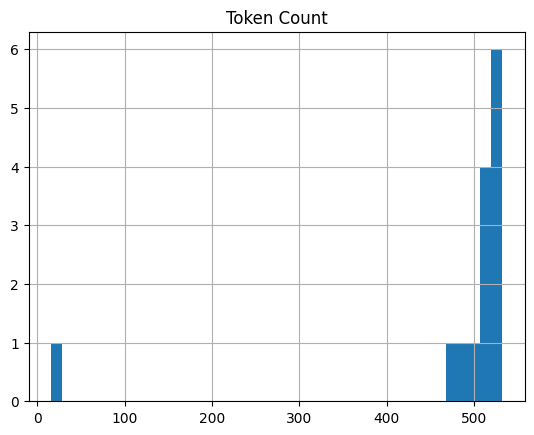

In [23]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [24]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [16]:
# Check similarity search is working
query = "لماذا لا يجوز الدفن في المساجد ؟"
docs = db.similarity_search(query)
docs[0]

Document(page_content='23 \n\n( قفاولما\n\n) \n\n1438\n\n(\n نا\n\n   ضمر نم نيشّعلاو\n\n \n\nنماَّثلا\n\n ًيرطا.  \n\n   م  تس\n\nا ًّشر اهئار\n\n نمو\n\nو  َّنإ\n\n ، ةعينش   ةلعف\n\nو ةيرطخ ةقباس يهو\n\n ،دجس\n\nلما\n\n ءا نفب دجسلما\n\n ن م ـ ةَّن  سلا روهظو ملعلا راشتنا نم \n\nينن ِّسلا هذه\n\n \n\n  ِّلك دعب ـ ةَّيرئازلجا انتَّم أ في يقب هَّنأ   نظن اَّنك ام\n\n انَّنإو\n\n تاب\n\n  تع دنع\n \n\n ِهوجولا غيرتمو ة\n\n  حضرلأا ميظعتو\n\nة \n\n َّيروبقلا\n\n نمز\n\n \n\nن \n\n  َّضلا\n\n،ةعدبلاو ةللا\n\n  ديري\n \n ِهاشلما\n.مشاغلا رماعتسلّا ماَّيأو لهلجا نمز ،\nد\n\n  مز لىإ انب\n\n  دوعي نأ', metadata={})

In [25]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "لماذا لا يجوز الدفن في المساجد ؟"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' لأن المساجد يتم استخدامها للصلاة والذكر والتذكير بالله، ولذلك لا يجوز الدفن فيها.'

# 5. Create chatbot with chat memory 

In [26]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)